In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = "myData2.parquet"
df = pd.read_parquet(file_path)

In [3]:
selected_features = ['timestamp_seconds', 
                     'node_memory_Percpu_bytes', 
                     'node_context_switches_total', 
                     'surfsara_power_usage', 
                     'node_netstat_Tcp_InSegs', 
                     'node_netstat_Tcp_OutSegs', 
                     'node_network_transmit_packets_total-sum', 
                     'node_filesystem_size_bytes-sum', 
                     'node_filesystem_files-sum', 
                     'node_memory_MemFree_bytes', 
                     'node_netstat_Tcp_InErrs']


In [65]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

In [100]:
# df_selected.head(20)
# df['state'].value_counts()
# df.info(max_cols=100)
# data.head(20)
# df_selected

In [19]:
# Define time intervals
time_intervals = {'minute': '1T', 'hour': '1H', 'day': '1D'}

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])

# Set sequence length
sequence_length = 30

# Number of time steps to predict into the future
prediction_steps = 7

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [112]:
# Function to prepare data for LSTM
def prepare_lstm_data(data, time_interval):
    data.set_index('timestamp', inplace=True)
    data_resampled = data.resample(time_interval).sum()
    # data_resampled['target'] = data_resampled['target'].clip(upper=1)  # Clip values to 1
    return data_resampled



In [111]:
# Function to create sequences for LSTM
def create_lstm_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]['target']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [113]:
# Function to make predictions on new data
def predict_future_failures(model, input_data, sequence_length, prediction_steps):
    predictions = []

    for _ in range(prediction_steps):
        # Make a prediction for the next time step
        prediction = model.predict(input_data.reshape(1, sequence_length, input_data.shape[1]))
        predictions.append(prediction[0, 0])

        # Shift the input data by one time step and append the new prediction
        input_data = np.roll(input_data, shift=-1, axis=0)
        input_data[-1, -1] = prediction[0, 0]

    return predictions


# 30 days -> 7 days

In [129]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)


In [130]:
# Prepare data for LSTM with daily intervals
lstm_data_day = prepare_lstm_data(df_selected, time_intervals['day'])

# Create sequences and targets
sequences_day, targets_day = create_lstm_sequences(lstm_data_day, sequence_length)

# Split the data into training and testing sets
X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(sequences_day, targets_day, test_size=0.3, random_state=1)


In [131]:
# Build the LSTM model
lstm_model_day = Sequential()
lstm_model_day.add(LSTM(50, input_shape=(X_train_day.shape[1], X_train_day.shape[2])))
lstm_model_day.add(Dense(1, activation='linear'))
lstm_model_day.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_day = lstm_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
2/2 [==============================] - 2s 511ms/step - loss: 4114.4126 - mean_squared_error: 6979764.0000 - val_loss: 7193.9653 - val_mean_squared_error: 16593069.0000
Epoch 2/20
2/2 [==============================] - 0s 67ms/step - loss: 3626.9978 - mean_squared_error: 6979689.5000 - val_loss: 6493.9883 - val_mean_squared_error: 16592957.0000
Epoch 3/20
2/2 [==============================] - 0s 65ms/step - loss: 3265.8958 - mean_squared_error: 6979620.5000 - val_loss: 5916.0220 - val_mean_squared_error: 16592847.0000
Epoch 4/20
2/2 [==============================] - 0s 65ms/step - loss: 2944.8291 - mean_squared_error: 6979550.0000 - val_loss: 5429.3970 - val_mean_squared_error: 16592741.0000
Epoch 5/20
2/2 [==============================] - 0s 67ms/step - loss: 2702.3877 - mean_squared_error: 6979486.0000 - val_loss: 5001.8276 - val_mean_squared_error: 16592635.0000
Epoch 6/20
2/2 [==============================] - 0s 67ms/step - loss: 2448.8506 - mean_squared_error: 697941

In [123]:
# from collections import Counter

# # Count the occurrences of each unique value
# count = Counter(y_train_day)

# # Print the counts
# for value, frequency in count.items():
#     print(f"{value}: {frequency}")


In [132]:
# Evaluate the model using Mean Squared Error
mse_day = lstm_model_day.evaluate(X_test_day, y_test_day, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_day:.4f}\n')

input_data = X_test_day[3]  # Can be any valid starting point

# Make predictions
predicted_failures = predict_future_failures(lstm_model_day, input_data, sequence_length, prediction_steps)

# Denormalize the predicted failures 
predicted_failures_denormalized = predicted_failures * (lstm_data_day['target'].max() - lstm_data_day['target'].min()) + lstm_data_day['target'].min()

# Print the predicted failures
print("Predicted failures for the next 7 days:")
print(predicted_failures_denormalized)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures - y_test_day[3:3+prediction_steps])**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures - y_test_day[3:3+prediction_steps]))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')


Model Mean Squared Error: 18463732.0000

1/1 [==============================] - 0s 20ms/step
Predicted failures for the next 7 days:
[0.3406006 0.3406006 0.3406006 ... 0.3406006 0.3406006 0.3406006]

Mean Squared Error for Predictions: 48205535.5954

Mean Absolute Error for Predictions: 5123.5165


### Performance


#### Training and Validation Loss Plot

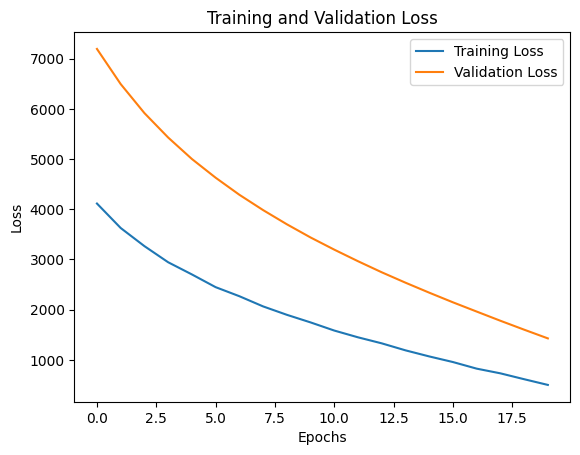

In [133]:
# Plot training and validation loss
plt.plot(history_day.history['loss'], label='Training Loss')
plt.plot(history_day.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


#### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 19ms/step


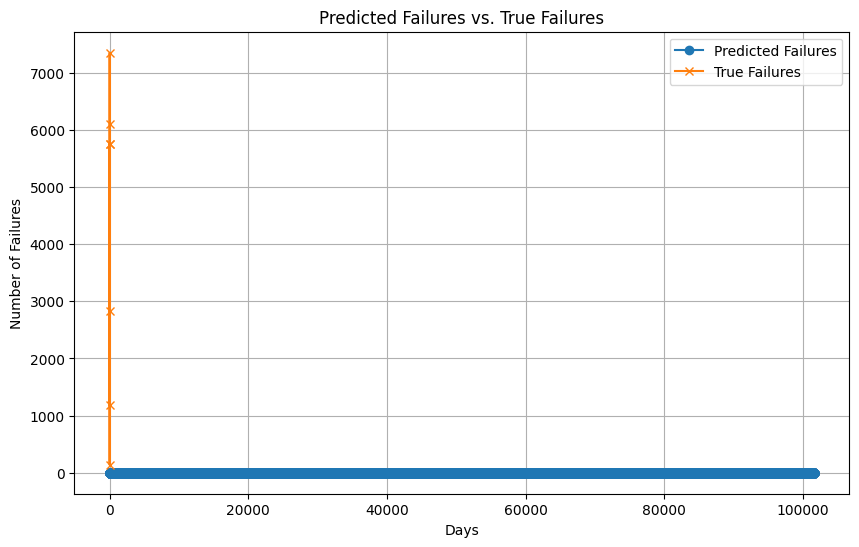

In [134]:
# Define the number of days to make predictions
num_days = 7  # Change if needed

# Make predictions for the specified number of days
predicted_failures = predict_future_failures(lstm_model_day, input_data, sequence_length, num_days)

# Denormalize the predicted failures 
predicted_failures_denormalized = predicted_failures * (lstm_data_day['target'].max() - lstm_data_day['target'].min()) + lstm_data_day['target'].min()

# Get the true failures for the specified number of days
true_failures = y_test_day[0:0+num_days]  # Adjust the range as needed

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_denormalized, label='Predicted Failures', marker='o')
plt.plot(true_failures, label='True Failures', marker='x')
plt.xlabel('Days')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()


# 30 hours -> 7 hours

In [ ]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

In [14]:
# Prepare data for LSTM with hourly intervals
lstm_data_hour = prepare_lstm_data(df_selected, time_intervals['hour'])

# Create sequences and targets
sequences_hour, targets_hour = create_lstm_sequences(lstm_data_hour, sequence_length)

# Split the data into training and testing sets
X_train_hour, X_test_hour, y_train_hour, y_test_hour = train_test_split(sequences_hour, targets_hour, test_size=0.3, random_state=1)

# Build the LSTM model
lstm_model_hour = Sequential()
lstm_model_hour.add(LSTM(20, input_shape=(X_train_hour.shape[1], X_train_hour.shape[2])))
lstm_model_hour.add(Dense(1, activation='sigmoid'))
lstm_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
lstm_model_hour.fit(X_train_hour, y_train_hour, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/20
54/54 [==============================] - 3s 29ms/step - loss: 0.2212 - mean_squared_error: 0.2212 - val_loss: 0.1896 - val_mean_squared_error: 0.1896
Epoch 2/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1781 - mean_squared_error: 0.1781 - val_loss: 0.1630 - val_mean_squared_error: 0.1630
Epoch 3/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1504 - val_mean_squared_error: 0.1504
Epoch 4/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1523 - mean_squared_error: 0.1523 - val_loss: 0.1426 - val_mean_squared_error: 0.1426
Epoch 5/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1479 - mean_squared_error: 0.1479 - val_loss: 0.1411 - val_mean_squared_error: 0.1411
Epoch 6/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1436 - mean_squared_error: 0.1436 - val_loss: 0.1425 - val_mean_squared_error: 0.1425
Epoch 7/20
54/54 [================

In [15]:
# Evaluate the model using Mean Squared Error
mse_hour = lstm_model_hour.evaluate(X_test_hour, y_test_hour, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_hour:.4f}\n')

input_data = X_test_hour[3]  # Can be any valid starting point

# Make predictions
predicted_failures = predict_future_failures(lstm_model_hour, input_data, sequence_length, prediction_steps)

# Denormalize the predicted failures 
predicted_failures_denormalized = predicted_failures * (lstm_data_hour['target'].max() - lstm_data_hour['target'].min()) + lstm_data_hour['target'].min()

# Print the predicted failures
print("Predicted Failures for the Next 7 Hours:")
print(predicted_failures_denormalized)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures - y_test_hour[3:3+prediction_steps])**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures - y_test_hour[3:3+prediction_steps]))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')



Model Mean Squared Error: 0.1258

1/1 [==============================] - 0s 19ms/step
Predicted Failures for the Next 7 Hours:
[0.48869568 0.4911451  0.48555914 0.4851614  0.48672578 0.49587646
 0.5405644 ]

Mean Squared Error for Predictions: 0.2536

Mean Absolute Error for Predictions: 0.5033


#### Predicted Failures vs. True Failures Plot

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


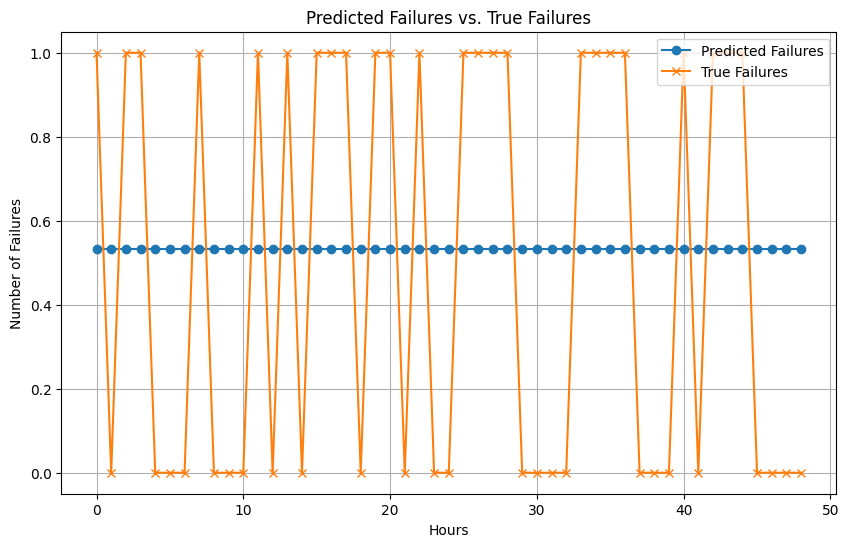

In [52]:
# Define the number of hours to make predictions
num_hours = 49  # Change if needed

# Make predictions for the specified number of hours
predicted_failures = predict_future_failures(lstm_model_hour, input_data, sequence_length, num_hours)

# Denormalize the predicted failures 
predicted_failures_denormalized = predicted_failures * (lstm_data_hour['target'].max() - lstm_data_hour['target'].min()) + lstm_data_hour['target'].min()

# Get the true failures for the specified number of hours
true_failures = y_test_hour[0:0+num_hours]  # Adjust the range as needed

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_denormalized, label='Predicted Failures', marker='o')
plt.plot(true_failures, label='True Failures', marker='x')
plt.xlabel('Hours')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()


# 30 minutes -> 7 minutes - Overfitting

In [ ]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)


In [22]:
# Prepare data for LSTM with minute intervals
lstm_data_minute = prepare_lstm_data(df_selected, time_intervals['minute'])

# Create sequences and targets
sequences_minute, targets_minute = create_lstm_sequences(lstm_data_minute, sequence_length)

# Split the data into training and testing sets
X_train_minute, X_test_minute, y_train_minute, y_test_minute = train_test_split(sequences_minute, targets_minute, test_size=0.3, random_state=1)

# Build the LSTM model
lstm_model_minute = Sequential()

# 50 -> 10
lstm_model_minute.add(LSTM(10, input_shape=(X_train_minute.shape[1], X_train_minute.shape[2])))
lstm_model_minute.add(Dense(1, activation='sigmoid'))
lstm_model_minute.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
lstm_model_minute.fit(X_train_minute, y_train_minute, epochs=5, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/5
3258/3258 [==============================] - 66s 20ms/step - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.1985 - val_mean_squared_error: 0.1985
Epoch 2/5
3258/3258 [==============================] - 63s 19ms/step - loss: 0.1973 - mean_squared_error: 0.1973 - val_loss: 0.1956 - val_mean_squared_error: 0.1956
Epoch 3/5
3258/3258 [==============================] - 63s 19ms/step - loss: 0.1949 - mean_squared_error: 0.1949 - val_loss: 0.1935 - val_mean_squared_error: 0.1935
Epoch 4/5
3258/3258 [==============================] - 62s 19ms/step - loss: 0.1936 - mean_squared_error: 0.1936 - val_loss: 0.1927 - val_mean_squared_error: 0.1927
Epoch 5/5
3258/3258 [==============================] - 62s 19ms/step - loss: 0.1930 - mean_squared_error: 0.1930 - val_loss: 0.1922 - val_mean_squared_error: 0.1922


In [23]:
# Evaluate the model using Mean Squared Error
mse_minute = lstm_model_minute.evaluate(X_test_minute, y_test_minute, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_minute:.4f}\n')

input_data = X_test_minute[3]  # Can be any valid starting point

# Make predictions
predicted_failures = predict_future_failures(lstm_model_minute, input_data, sequence_length, prediction_steps)

# Denormalize the predicted failures
predicted_failures_denormalized = predicted_failures * (lstm_data_minute['target'].max() - lstm_data_minute['target'].min()) + lstm_data_minute['target'].min()

# Print the predicted failures
print("Predicted failures for the next 7 minutes:")
print(predicted_failures_denormalized)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures - y_test_minute[3:3+prediction_steps])**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures - y_test_minute[3:3+prediction_steps]))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')


Model Mean Squared Error: 0.1924

1/1 [==============================] - 0s 19ms/step
Predicted failures for the next 7 minutes:
[0.5120347 0.5120347 0.5120347 0.5120347 0.5120347 0.5120347 0.5120347]

Mean Squared Error for Predictions: 0.2519

Mean Absolute Error for Predictions: 0.5017


### Performance

In [24]:
# Performance Metrics Tables

# Create a DataFrame for performance metrics
performance_metrics = pd.DataFrame({
    'Time Granularity': ['Daily', 'Hourly', 'Minute'],
    'Mean Squared Error': [mse_day, mse_hour, mse_minute]
})

# Print the performance metrics table
print("Performance Metrics Table:")
print(performance_metrics)


Performance Metrics Table:
  Time Granularity  Mean Squared Error
0            Daily            0.147957
1           Hourly            0.125769
2           Minute            0.192410


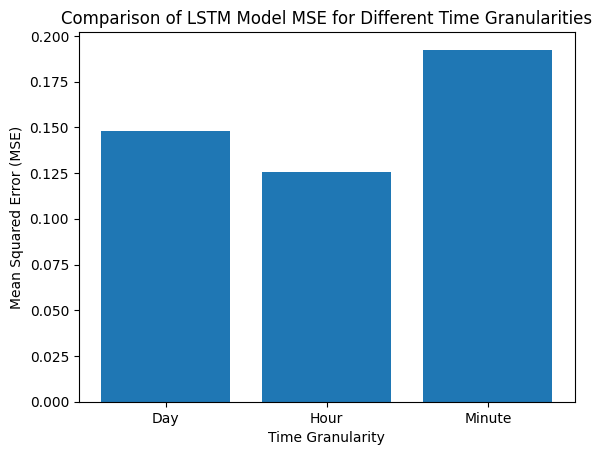

In [32]:
# Plot MSE for different time granularities
time_granularities = ['Day', 'Hour', 'Minute']
mse_values = [mse_day, mse_hour, mse_minute]

plt.bar(time_granularities, mse_values)
plt.title('Comparison of LSTM Model MSE for Different Time Granularities')
plt.xlabel('Time Granularity')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()
